In [16]:
import pandas as pd #imports more are used later as I need them
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
import csv
import io
import sys
from google.colab import files

In [4]:
file = files.upload() #upload the file

Saving games.csv to games.csv


In [18]:
df = pd.read_csv(io.StringIO(file['games.csv'].decode('utf-8'))) #read the file
df.shape

(20058, 16)

In [6]:
df.describe()
len(df["opening_name"].value_counts()) #there are over 1400 openings, but not that man openings exist, we can clean this data up significantly

1477

In [7]:
#the below block of code is from https://www.kaggle.com/code/mariuskunauskas/analyzing-chess-data for cleaning up number of openings
df["opening_name"] = df["opening_name"].apply(lambda x: x.split(":")[0]) 
df["opening_name"] = df["opening_name"].apply(lambda x: x.split(" |")[0]) 
df["opening_name"] = df["opening_name"].apply(lambda x: x.split(" #")[0])
df["opening_name"] = df["opening_name"].apply(lambda x: x.split(" Accepted")[0])
df["opening_name"] = df["opening_name"].apply(lambda x: x.split(" Declined")[0])
df["opening_name"] = df["opening_name"].apply(lambda x: x.split(" Refused")[0])

df["opening_name"].replace("King's Pawn Game", "King's Pawn", inplace = True)
df["opening_name"].replace("King's Pawn Opening", "King's Pawn", inplace = True)
df["opening_name"].replace("Old Indian Defense", "Old Indian", inplace = True)
df["opening_name"].replace("Queen's Pawn Game", "Queen's Pawn", inplace = True)
df["opening_name"].replace("Queen's Pawn Opening", "Queen's Pawn", inplace = True)
df["opening_name"].replace("Ware Defense", "Ware Opening", inplace = True)
len(df["opening_name"].value_counts())

122

In [8]:
df = df.drop(['id', 'white_id', 'black_id', 'opening_eco','moves', 'rated'], axis=1) #dropping columns I have decided to not use

In [9]:
features = df.columns
features = features.drop(['winner']) #remove from what will be our X value
print(features)

Index(['created_at', 'last_move_at', 'turns', 'victory_status',
       'increment_code', 'white_rating', 'black_rating', 'opening_name',
       'opening_ply'],
      dtype='object')


In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder 

enc = OrdinalEncoder() #needed for our categorical data
pca = PCA(0.96)
X = df.loc[:,features].values
X = enc.fit_transform(X) #encoding categorical
target = df['winner'] #target (y) is set to be the winner as that is what we want to predict
y = df.loc[:,['winner']]
pca.fit_transform(X)




array([[-7430.0859381 ],
       [-7041.08873799],
       [-7044.0352013 ],
       ...,
       [-1486.47440441],
       [-1485.60505356],
       [-1479.22126472]])

In [11]:
pca.explained_variance_ratio_ #explanation of this can be found in the data exploration of the report


array([0.99339632])

0.7149194201695813


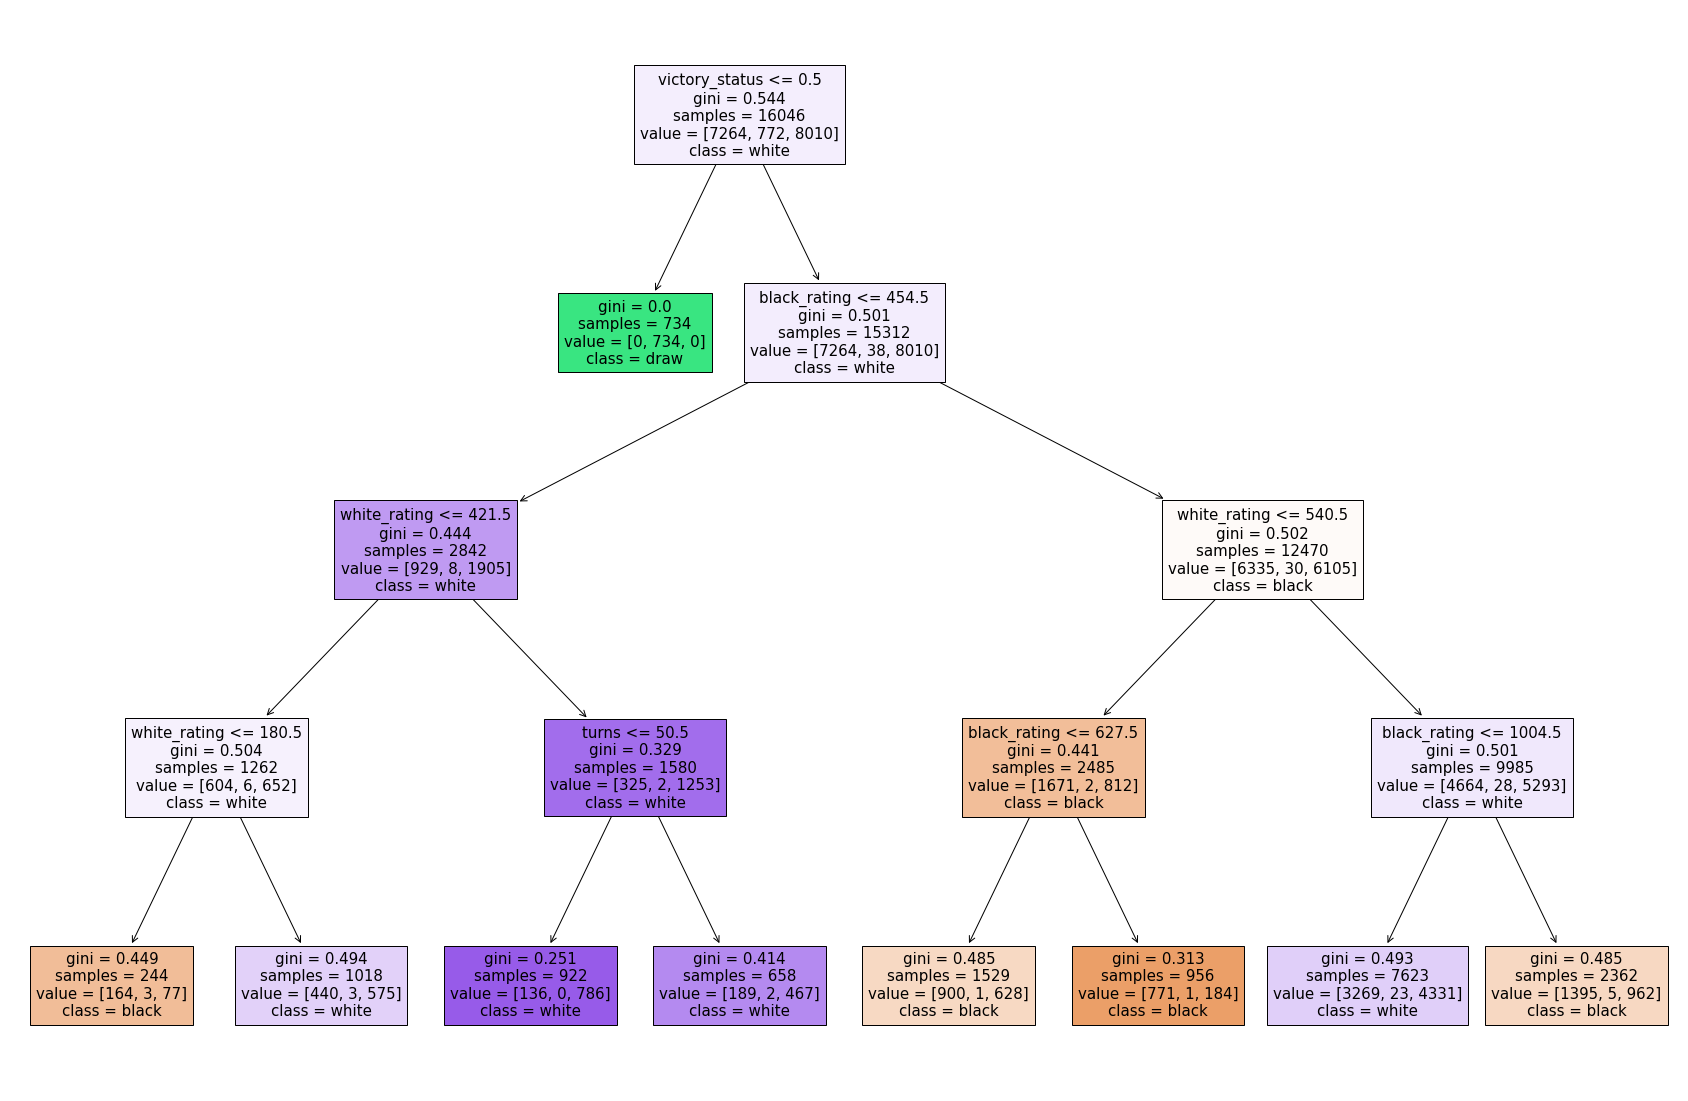

In [12]:
from sklearn.tree import DecisionTreeClassifier, plot_tree 
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
X_train, X_test, y_train, y_test = train_test_split(X,y.values.ravel(),test_size=0.2) #generate training and testing values (it was getting mad at me so I used .ravel to get rid of the errors)
clf_tree = DecisionTreeClassifier(max_depth=4) #creation of decision tree
clf_tree.fit(X_train, y_train) #training
y_pred = clf_tree.predict(X_test) #predicition
print(f1_score(y_test,y_pred, average='macro'))
plt.figure(figsize=(30,20))
_ = plot_tree(clf_tree, feature_names = features, class_names= clf_tree.classes_, filled=True) #plot figure, noted as Fig. 1 in report

Fig. 1 

In [39]:
import sklearn.neural_network as nn #MLP model testing
from sklearn.metrics import accuracy_score
clf_mlp = nn.MLPClassifier(hidden_layer_sizes=(10,5), max_iter=1000, activation='logistic', alpha=0.0)
clf_mlp.fit(X_train, y_train)
y_pred = clf_mlp.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.6124127617148555


In [40]:
from sklearn.ensemble import RandomForestClassifier #Random Forest model testing
clf_rf = RandomForestClassifier(max_depth=5,n_estimators=300)
clf_rf.fit(X_train, y_train)
y_pred = clf_rf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.6669990029910269


In [43]:
from sklearn.ensemble import GradientBoostingClassifier #GradientBoosting model testing
from sklearn.metrics import r2_score

clf_gb = GradientBoostingClassifier(n_estimators=100)
clf_gb.fit(X_train, y_train)
y_pred = clf_gb.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.7627118644067796


In [ ]:
from sklearn.ensemble import AdaBoostClassifier #AdaBoost model testing
clf_ab = AdaBoostClassifier(n_estimators=100)
clf_ab.fit(X_train, y_train)
y_pred = clf_ab.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.5682951146560319


In [ ]:
from pandas.core.common import random_state
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

#trying to tune the MLP model using GridSearch
param_grid = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)], 
              'activation': ['logistic', 'tanh', 'relu'],
              'solver': ['sgd', 'adam'],
              'alpha': [0.0, 0.0001, 0.05],
              'learning_rate': ['constant', 'adaptive']}
grid = GridSearchCV(clf_mlp, param_grid, cv = 3, n_jobs = -1 )
grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=MLPClassifier(activation='logistic', alpha=0.0,
                                     hidden_layer_sizes=(10, 5),
                                     max_iter=1000),
             n_jobs=-1,
             param_grid={'activation': ['logistic', 'tanh', 'relu'],
                         'alpha': [0.0, 0.0001, 0.05],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                                (100,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [ ]:
print('Best parameters found: ', grid.best_params_)

Best parameters found:  {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'sgd'}


In [49]:
from sklearn.metrics import classification_report
clf = nn.MLPClassifier(hidden_layer_sizes=(100,), activation= 'logistic', alpha=0.0001, learning_rate='adaptive', solver= 'sgd') #plugging in best parameters found in grid search 

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.6208873379860419


In [ ]:
gboost_grid = {'n_estimators' : [10, 50, 100, 200, 300, 400]} #tuning the GradientBoost model with GridSearch
grid = GridSearchCV(clf_gb, gboost_grid, cv = 3, n_jobs= -1)
grid.fit(X_train, y_train)


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(n_estimators=200),
             n_jobs=-1,
             param_grid={'n_estimators': [10, 50, 100, 200, 300, 400]})

In [ ]:
print('Best parameters found: ', grid.best_params_)

Best parameters found:  {'n_estimators': 400}


In [53]:
clf_gb = GradientBoostingClassifier(n_estimators=400) #plugging in best value
clf_gb.fit(X_train, y_train)
y_pred = clf_gb.predict(X_test) 
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

0.8910767696909272
              precision    recall  f1-score   support

       black       0.89      0.88      0.88      1850
        draw       0.99      0.95      0.97       202
       white       0.88      0.90      0.89      1960

    accuracy                           0.89      4012
   macro avg       0.92      0.91      0.91      4012
weighted avg       0.89      0.89      0.89      4012



In [13]:
from sklearn.model_selection import ShuffleSplit 
shuf = ShuffleSplit(n_splits=3, test_size=.2)
shuf.get_n_splits(X) #for cross validation

3

In [56]:
from sklearn.model_selection import cross_val_score

score = cross_val_score(clf_gb, X, y, scoring = 'accuracy', cv=shuf) #cross validation

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [57]:
print(score)

[0.88958126 0.88085743 0.89431705]


In [51]:
clf_gb = GradientBoostingClassifier(n_estimators=200) #seeing the result of trying to improve execution time
clf_gb.fit(X_train, y_train)
y_pred = clf_gb.predict(X_test)
print(accuracy_score(y_test,y_pred)) 

0.8541874376869392


400 estimators is marginally better than 200 estimators, much longer execution time.

In [52]:
clf_gb = GradientBoostingClassifier(n_estimators=150) #further improving executtion time
clf_gb.fit(X_train, y_train)
y_pred = clf_gb.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.8212861415752741
